In [ ]:
import pandas as pd
import os


excel_path =  r"All_MICE_VIDEO_DAYS.xlsx"
max_gap_seconds = 30  # max inter-pellet gap for merging into same cluster


excel_data = pd.read_excel(excel_path, sheet_name=None)


cluster_summary = []

for sheet_name, df in excel_data.items():
    df = df[df["Event"] == "Pellet"].copy()
    if df.empty:
        cluster_summary.append({
            "Mouse_ID": sheet_name,
            "Device_Number": "Unknown",
            "Pellet_Count": 0,
            "Pellet_Clusters": 0
        })
        continue

    # Parse timestamp
    df["Timestamp"] = pd.to_datetime(df["MM/DD/YYYY hh:mm:ss.SSS"])
    df = df.sort_values("Timestamp")

    # Calculate inter-pellet gap
    df["Time_Diff"] = df["Timestamp"].diff().dt.total_seconds()

    # Define cluster: start new when time diff > 30 sec
    df["Cluster"] = (df["Time_Diff"] > max_gap_seconds).cumsum()

    # Count unique clusters
    pellet_clusters = df["Cluster"].nunique()
    device_number = df["Device_Number"].iloc[0] if "Device_Number" in df.columns else "Unknown"

    cluster_summary.append({
        "Mouse_ID": sheet_name,
        "Device_Number": device_number,
        "Pellet_Count": len(df),
        "Pellet_Clusters": pellet_clusters
    })

# Convert to DataFrame and save
cluster_df = pd.DataFrame(cluster_summary)
print(cluster_df)


# output_csv = os.path.join(os.path.dirname(excel_path), "pellet_clusters_per_mouse.csv")
# cluster_df.to_csv(output_csv, index=False)
# print(f"\nSaved summary to: {output_csv}")


   Mouse_ID  Device_Number  Pellet_Count  Pellet_Clusters
0   FOTOA01              9           266               57
1   FOTOA02              2           209               65
2   FOTOA03              3           238               70
3   FOTOA04             16           234               66
4   FOTOA05              5           204              134
5   FOTOA06             15           182               70
6   FOTOA07              6           161               18
7   FOTOA08             12           163               59
8   FOTOA09              9           260              146
9   FOTOA10              7           213               86
10  FOTOA11             13           211               45
11  FOTOA12             16           235               55


C:\Users\hta031\AppData\Local\Temp\ipykernel_62448\151075578.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("tab10", n_mice)


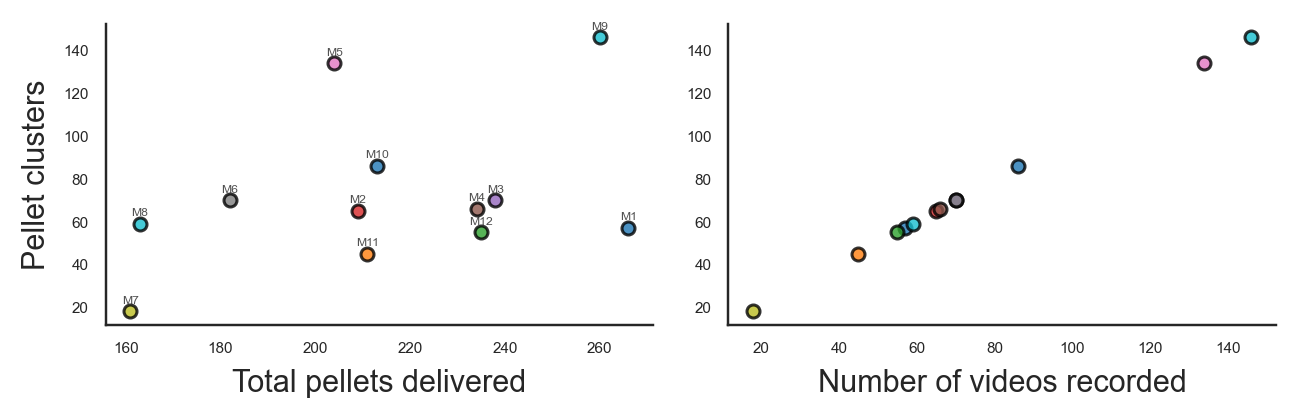

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
dpi_val = 220
excel_path = r"All_MICE_VIDEO_DAYS.xlsx"
max_gap_seconds = 30  # seconds between pellets to define a new cluster


excel_data = pd.read_excel(excel_path, sheet_name=None)


cluster_summary = []

for sheet_name, df in excel_data.items():
    df = df[df["Event"] == "Pellet"].copy()
    if df.empty:
        cluster_summary.append({
            "Mouse_ID": f"M{len(cluster_summary)+1}",
            "Original_Label": sheet_name,
            "Device_Number": "Unknown",
            "Pellet_Count": 0,
            "Pellet_Clusters": 0
        })
        continue

    # Timestamp parsing
    df["Timestamp"] = pd.to_datetime(df["MM/DD/YYYY hh:mm:ss.SSS"])
    df = df.sort_values("Timestamp")

    # Calculate gap between pellets
    df["Time_Diff"] = df["Timestamp"].diff().dt.total_seconds()
    df["Cluster"] = (df["Time_Diff"] > max_gap_seconds).cumsum()

    cluster_summary.append({
        "Mouse_ID": f"M{len(cluster_summary)+1}",
        "Original_Label": sheet_name,
        "Device_Number": df["Device_Number"].iloc[0] if "Device_Number" in df.columns else "Unknown",
        "Pellet_Count": len(df),
        "Pellet_Clusters": df["Cluster"].nunique()
    })


cluster_df = pd.DataFrame(cluster_summary)


mouse_summary = (
    cluster_df.groupby("Mouse_ID")
    .agg(
        Total_Pellets=("Pellet_Count", "sum"),
        Total_Clusters=("Pellet_Clusters", "sum")
    )
    .reset_index()
)


n_mice = len(mouse_summary)
colormap = cm.get_cmap("tab10", n_mice)
color_dict = {
    mouse_id: colormap(i) for i, mouse_id in enumerate(mouse_summary["Mouse_ID"])
}
mouse_summary["Color"] = mouse_summary["Mouse_ID"].map(color_dict)


sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(6.0, 2.0), dpi=220)


ax = axes[0]
for _, row in mouse_summary.iterrows():
    ax.scatter(
        row["Total_Pellets"],
        row["Total_Clusters"],
        color=row["Color"],
        edgecolor="black",
        s=18,
        alpha=0.8,
        zorder=2
    )
    ax.annotate(
        row["Mouse_ID"],
        xy=(row["Total_Pellets"], row["Total_Clusters"]),
        xytext=(0, 2),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=4,
        alpha=0.8,
        zorder=3
    )

ax.set_xlabel("Total pellets delivered", fontsize=10)
ax.set_ylabel("Pellet clusters", fontsize=10)
ax.tick_params(axis="both", labelsize=5, length=2)
sns.despine(ax=ax)


ax = axes[1]
for _, row in mouse_summary.iterrows():
    ax.scatter(
        row["Total_Clusters"],  # x-axis = number of videos
        row["Total_Clusters"],  # y-axis = pellet clusters
        color=row["Color"],
        edgecolor="black",
        s=18,
        alpha=0.8,
        zorder=2
    )


# legend_elements = [
#     plt.Line2D([0], [0], marker='o', color='w', label=mouse,
#                markerfacecolor=color_dict[mouse], markersize=5, markeredgecolor='black')
#     for mouse in mouse_summary["Mouse_ID"]
# ]
# ax.legend(handles=legend_elements, title="Mouse ID", fontsize=5, title_fontsize=6, loc="upper left", bbox_to_anchor=(1, 1))

ax.set_xlabel("Number of videos recorded", fontsize=10)
ax.set_ylabel("", fontsize=2)
ax.tick_params(axis="both", labelsize=5, length=2)
sns.despine(ax=ax)
# plt.savefig("../plots_and_figs/Pellet_cluster_videos_count.pdf", dpi=dpi_val, bbox_inches="tight")  
plt.tight_layout()
plt.show()
